This notebook is based on this [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/text/transformer) and this amazing [video ](https://www.youtube.com/watch?v=iDulhoQ2pro&list=PL1v8zpldgH3pXDttKKp8mlVKDitxsYDAp&index=6)explaining the 'Attention is all you need' [paper](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

In [ ]:
import tensorflow as tf

## Transformer building block I: The attention mechanism


#### Terminology ####
The idea is to extract representations from the input/output sequence, each conceptualizing something else, to perform attention on. These representation are refferd to in Transformer models as:

**Key:** Description of what know and where we know it. Matrix: (input sequence length, depth)

**Value:** Actual Information. Matrix: (input sequence length, depth values)

**Query:** What we want to know. Matrix: (output sequence length, depth)




### Scaled Dot Product Attention ###
The Transformer architecture makes use of the scaled-dot product attention we discussed earlier and applies it to the different representations of the input/output sequence inroduced above. The general idea is to attend to different positions of the Keys dependent on the Query, whereas the keys represent certain information contained in the Values:

$$ Attention(Q,K,V) = softmax(\frac{Q K^ \top }{\sqrt{d}}) V$$

1.  $Q K^ \top$: This results in yet another matrix of size (input sequence length, output sequence length), which can be interpreted as an **alignment score**. This alignment score generally has exactly the same purpose, as the alignment scores in Bahdanau attention $e_{ti}$ -  large values mean query and key align well, small/negative values mean they do not align. In other words, for each vector in the key and query sequence we get a measure of how well they "match" or so to say if the respective key vector stores the information the respective query vector is interested in. 

2. $ \frac{Q K^ \top }{\sqrt{dk}}$ We **scale** the dot product by the root of the depth d of the key/query to combat large values and thus very small gradients when using softmax.

3. $softmax(\frac{Q K^ \top }{\sqrt{d}})$ We now take the score and using softmax convert them to something we can interpret as probabilities. We know have a **scoring distribution**. Every row of this distribution matrix, thus over the output sequence length dimension, should add up to 1.

4. $softmax(\frac{Q K^ \top }{\sqrt{d}}) V$ Now we multiply this scoring distribuion with the value matrix. This basically means **selecting** relevant information to the query from the values to use as output. The result will have the shape (query sequence length, depth_value).

The difference to Bahdanau attention is really that here we compute the attention for all sequence elements at the same time (contrary to step by step in the decoder)! Technically we get Value and Key from the encoder, and only the queries come from the decoder (but we will see that even this is not generally true), so for know (and simplifying it a bit) one can think of this as a parallel version of Bahdanau attention. 
Refer to the following graphic for further illustration and view the code below to see a computational example.


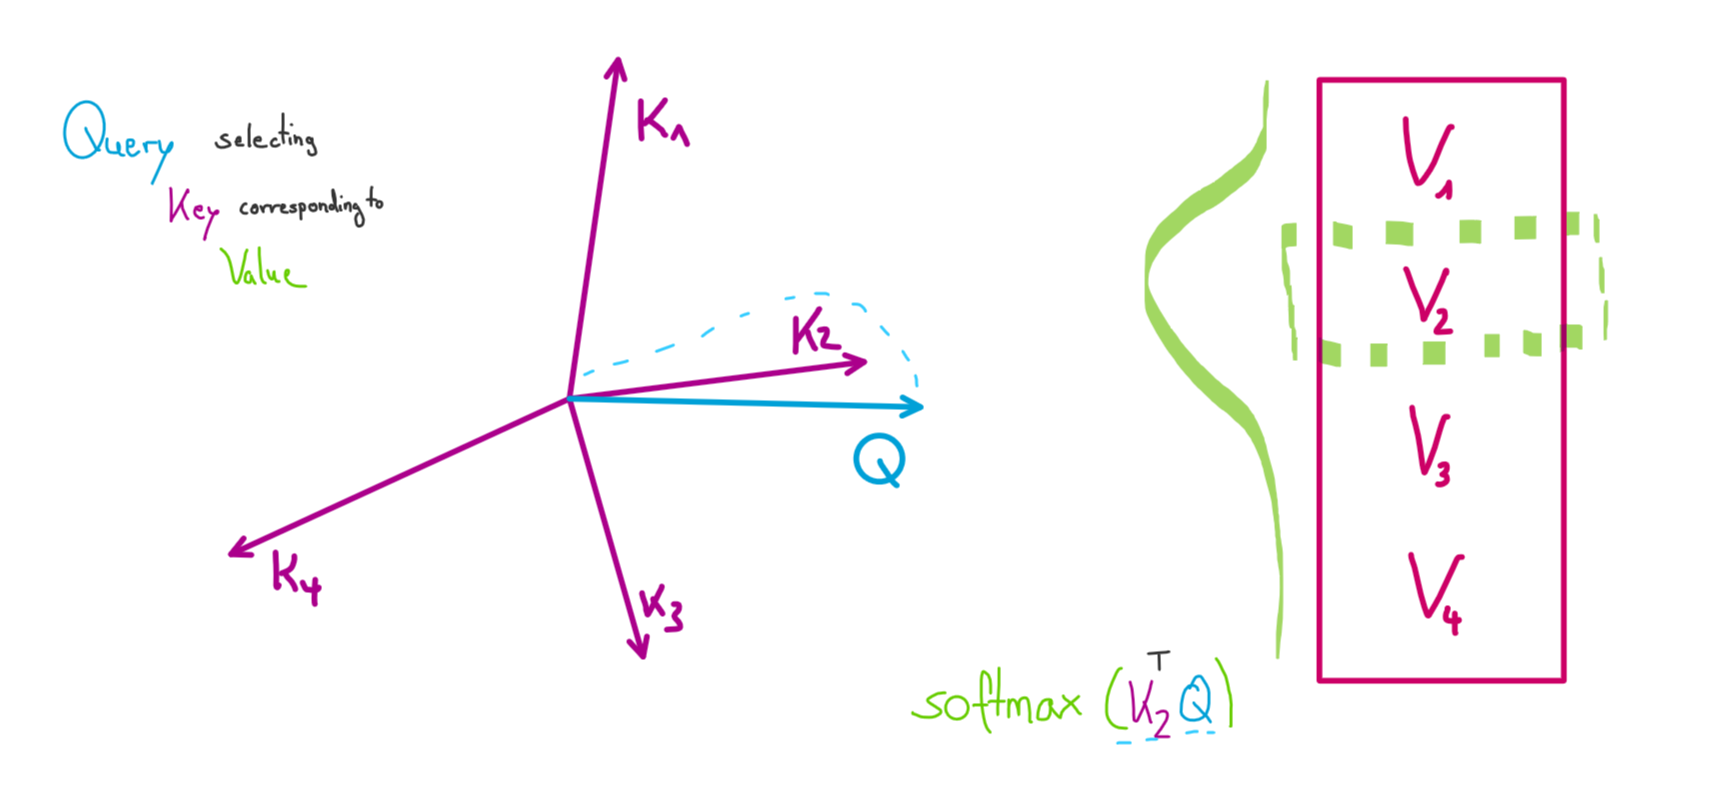

In [ ]:
def scaled_dot_product_attention(q, k, v, mask=None):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions (batch_size and number of heads in multi-head attention)
  k, v must have  matchig sequence length seq__kv
  the mask must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_q, dim_q)
    k: key shape == (..., seq_kv, dim_k)
    v: value shape == (..., seq_kv, dim_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  logits = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale logits
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = logits / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_kv) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_q, seq_kv)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, dim_v)

  return output, attention_weights

In [ ]:
seq_kv = 4 # sequence_length key == sequence_length value 
dim_qk =  6 # key and query must share same inner dimensionality
dim_v =  2 # value inner dimension
seq_q = 1 # sequence length query

batch_size = 1

# better example to see alignment
v = tf.ones((batch_size, seq_kv, dim_v)) 
k = tf.ones((batch_size, seq_kv, dim_qk))
q = tf.ones((batch_size, seq_q, dim_qk))


out, weights = scaled_dot_product_attention(q,k,v)

print(f"Output shpuld have the sequence length of the query {seq_q}, but the dimensionality of the values {dim_v}:")
print(out, '\n')
print(f"The attention weight matrix should be of size query sequence length x key/value sequence length: {seq_q} x {seq_kv}")
print(weights)

Output shpuld have the sequence length of the query 1, but the dimensionality of the values 2:
tf.Tensor([[[1. 1.]]], shape=(1, 1, 2), dtype=float32) 

The attention weight matrix should be of size query sequence length x key/value sequence length: 1 x 4
tf.Tensor([[[0.25 0.25 0.25 0.25]]], shape=(1, 1, 4), dtype=float32)


### Wait, what is this mask? ###

A attention based model usually gets the whole input and target sequenceand then learns when to attend to what information. Howeverr, as we later most probably want to make use of such a model in sequence task e.g. translation, where it actually will not be able to acces the whole sequence, we want to make sure the model also learns howw to do things without looking into the future.

Therefore, we just alter the input and mask everey information the model cannot have acces to yet - we call that future masking. 
In general, masking just means making part of the input unavailable / uninteresting to the model. 
In practice, this is done by creating a matrix of the same dimensionality as the input containing zeros and ones which is then substracted first multiplied by a really big negative value and then substracted from the scores of the input. Thus a zero indicates the value at the same location of theinput may be used as the score remains the same and a one means not to make us of it as the score becomes very very negative.

As we may deal with input and output sequences of different lengths we may also need to introduce a mask making sure padding values are not used as input.


## Transformer building block II:  Multi-Head-Attention ##

The main idea of a Multu-Head-Attention Block is to split the input (query, key, value) into multiple 'heads' which then each gets passed on to a different Scaled-Dot Product Attention block. The idea is to enable the model “ to jointly attend to information from different representation subspaces at different positions" (quote paper).

Important to note here is that (query, key, value)  are nt split along the dimension of the sequence length, but rather along the last dimension, nameley the depth of the model, which is equal to the inner dimensionality of the key/query and value.

E.g. You have a model depth of 10 and want to use 5 heads, then each head receives input of the dimensionality (...., sequence length, 10/5=2).

Before, we state that the value could be of a different last dimension, so we would need tomake sure that it is splitable by the number of heads we want to use. However,you will mostly encounter that query, key and value just share the same dimensionality which is then referred to as the model depth.

After the attention block, the outputs of each head are again rejoined.

So the procedure is the following:
1. Pass all inputs through a linear layer each with weights $W_{in}^Q,W_{in}^K, W_{in}^V$ to obtain $(Q', K',V')$
2. Split the transformed input into $n$ heads (along the last dimension) $ head_{i...n} = (Q',K',V')_{i...n}$
3. Compute attention for each head $head_i = Attention(Q'_i, K'_i, V'_i)$
4. concatinate the outputs of each head to obtain a single multi-head-attention output $mha = [head_i, ..., head_n]$ 
4. Pass output through a linear layer with weights $W_{out}$ to obtain the final output $mha'$

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, model_depth, num_heads):

    super(MultiHeadAttention, self).__init__()

    self.num_heads = num_heads
    self.model_depth = model_depth

    assert d_model % self.num_heads == 0
    # depth for each head
    self.depth = d_model // self.num_heads

    # linear layers before attention heads
    self.w_q = tf.keras.layers.Dense(d_model)
    self.w_k = tf.keras.layers.Dense(d_model)
    self.w_v = tf.keras.layers.Dense(d_model)

    # linear layer after attention heads
    self.w_out = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.w_q(q)  # (batch_size, seq_len, d_model)
    k = self.w_k(k)  # (batch_size, seq_len, d_model)
    v = self.w_v(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.w_out(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

##Transformer building block III: Architecture##

Now that we understand Multi-Head Attention, we can finally talk about transformers. Transformers are really where attention took of, and they are the architecture which made Scaled Dot-Product Attention famous: 

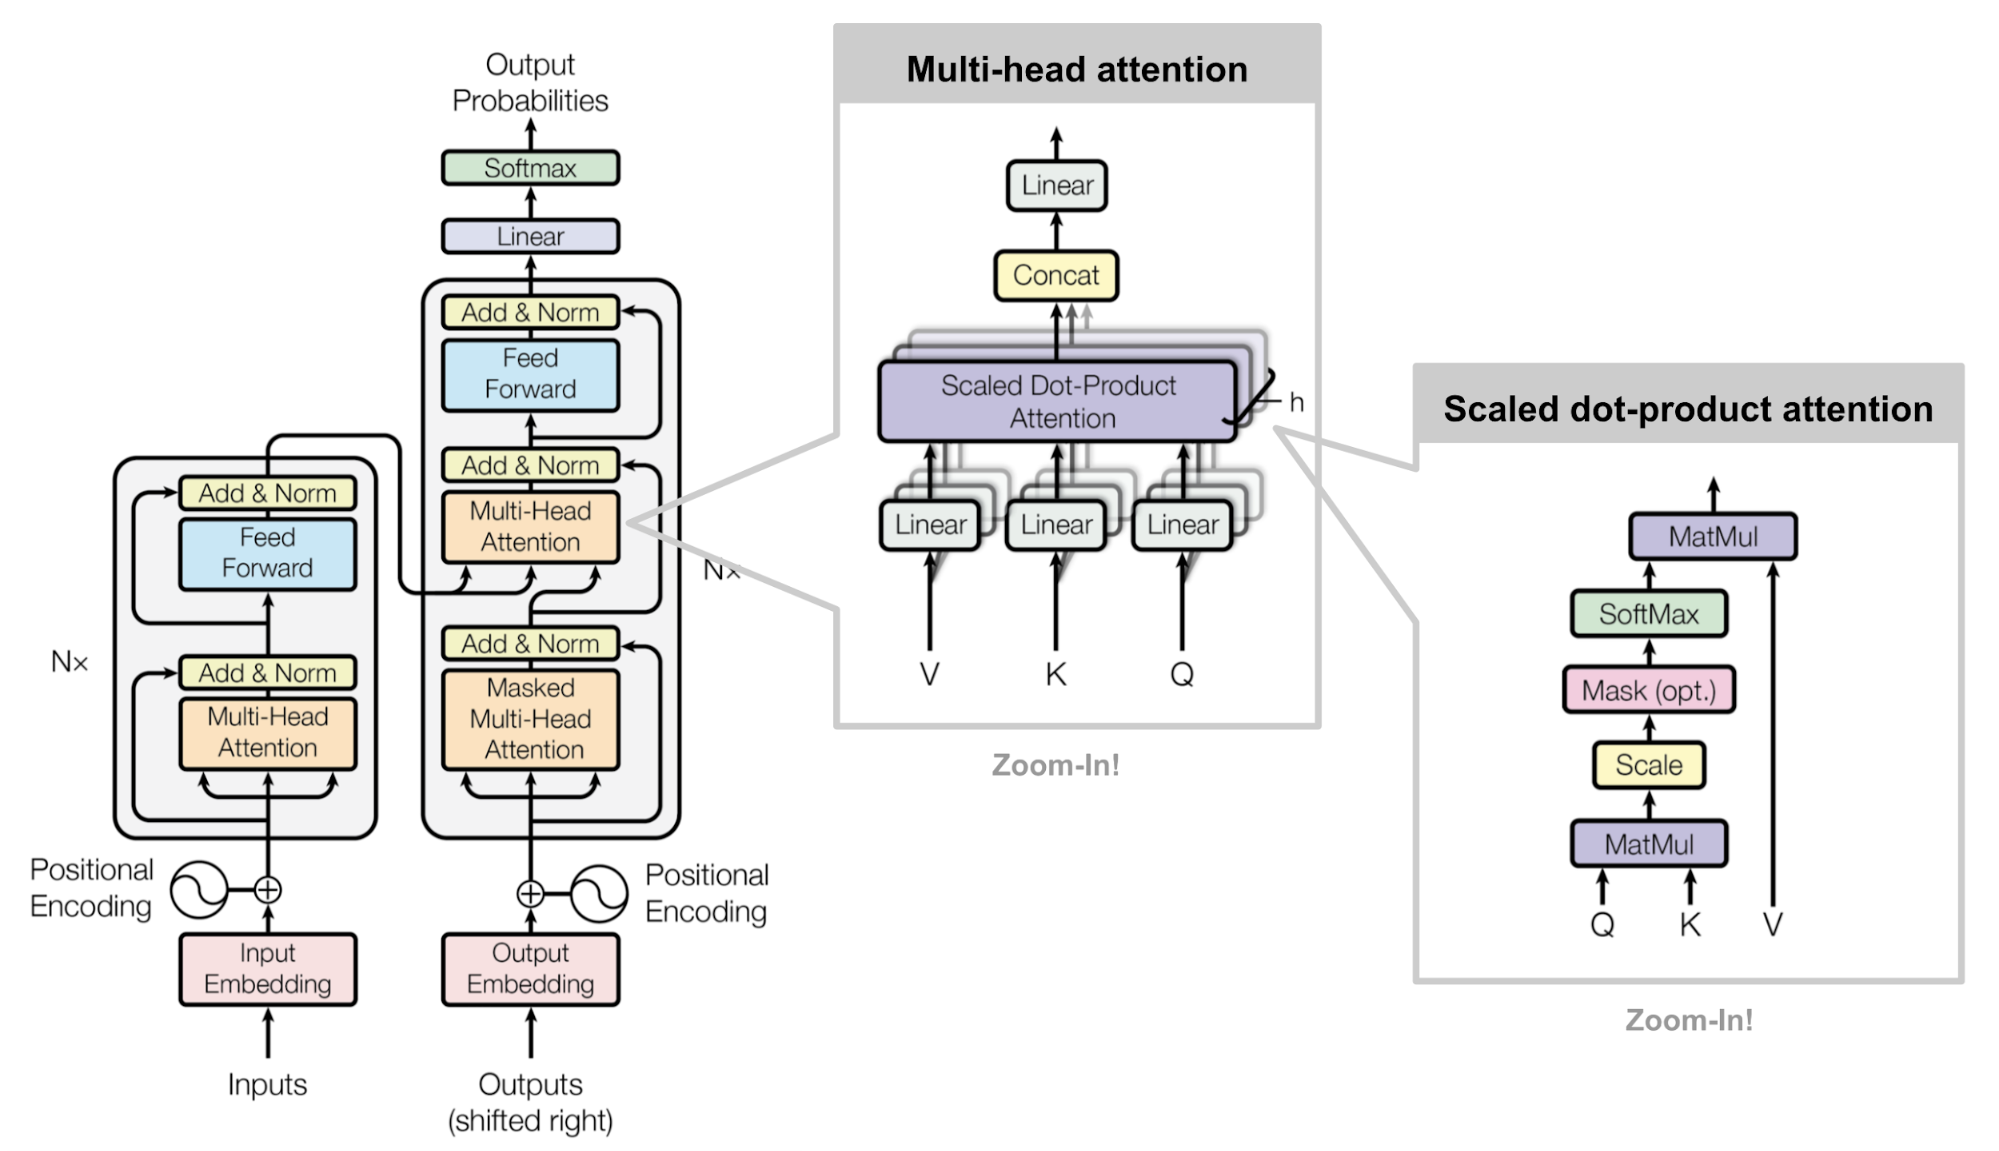

The [original paper by Vaswani et al.](https://arxiv.org/abs/1706.03762) is titled *Attention is all you need* and they really follow through with this: As you can see in the graphic above, while they keep the encoder-decoder architecture, there really is no RNN anymore! Instead the authors rely on self-attention - the sequence is attending itself here! Let's try to unpack this step by step: 
####Transformer Encoder####
The input for the transformer encoder takes the shape [batch_size, seq_len, dim]. Generally any subsequent layers take the form of *residual layers*, denoted by the **Add & Norm** blocks. You already know this mechanism from the lecture on advanced CNNs - ResNets, but additionally here a [Layer Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization) is used. We denote the layer wrapped by the residual layer as a Sublayer and write this as: LayerNorm(x + Sublayer(x)). [Layer Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization) is very similar to Batch Normalization, but instead of normalizing over the batch, the normalization is computed over the elements of the vector itself, such that the result is independent of other batch elements. 
Now finally we can understand how the self-attention mechanism works: Query, Key and Value are computed from the same input sequence for the Multi-Head Attention layer. That means that contrary to e.g. Bahdanau attention we discussed earlier, here the sequence is attending itself! 
The second part of each encoder block is then just a **Add & Norm** wrapped Feed forward network - specifically a Dense Layer with Relu activation followed by a Dense layer with Linear (i.e. no) activation. This combination of a **Add & Norm** wrapped Multi-Head Attention layer followed by **Add & Norm** wrapped Feed Forward network forms one encoder block, of which now several can be stacked. The only difference for subsequent blocks is of course, that their input is not the original input sequence, but rather the output from the Encoder block before it. In the original paper 6 of these blocks are stacked for the full encoder, the final output is now the encoding, which basically takes the same role as "thought vector" from RNN based seq2seq models. 
####Transformer Decoder####
The Decoder Block in the transformer is very similar to the Encoder Block: The input sequence for the first block is the part of the output sequence that has already been created. The first part of this block is a **Add & Norm** wrapped self attention block, just like the one we know from the encoder. The second block is again a **Add & Norm** wrapped Multi-Head Attention layer, but not a self-attending one: Key and Value are generated from the Encoder output, and only the Query is generated from the Decoder! This is where the model is still very similar to the Encoder-Decoder structure of RNN seq2seq models: Generating the query from the Decoder indeed means that the Decoder is attending the Encoder-output again. The final part of the Decoder Block is following the Encoder Block structure - an **Add & Norm** wrapped Feed Forward, again a Dense layer with RelU activation into a Dense layer with Linear (i.e. no) activation. 
Just like the encoder, multiple of these decoder blocks can be stacked, in the original paper six such blocks are used. 
After the final Decoder Block, the output is generated from a softmax as usual! 


## General remarks about Transformers and attention ##
* While it came up in the context of NLP, which is the prime-example of a sequence based task, the transformer style attention mechanism has actually no otion of sequences! Specifically there is no implicit order in the input sequence - while the input might indeed be ordered and subsequent words are therefor represented "next to each other" in the input sequence, this has indeed no effect for the dot-product (and the attention based on it)! In other words you could train the transformer model with an arbitrarily (fixed) permution of the input and output sequences without that making any difference at all.
* This actually hints at a very awesome property of this style of attention alyer: It is defined on set-like inputs - set of vector that is. For this reason, the transformer style attention mechanism is actually regarded as a more general approach to learning than even a classic MLP / Dense layer, which is based on a single vector only (of course for a dense layer these vectors could be unpacked, but in this process the information of this set-ordering would be lost)!
* While Transformers are awesome, they have a key downside, which is the motivation for many follow up papers: Because every sequence element can attend any other sequence element - specifically calculating the softmax on the dotproduct, it is quadratic in terms of memory and computing times with regards to the sequence length. 
